### Importing the Libraries

In [27]:
# Import the libraries
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

print("NLTK setup complete.")

NLTK setup complete.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load and Filter Data

In [29]:
file_path = '/content/sample_data/AirlineReviews.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable to the correct location of your CSV.")
    df = pd.DataFrame()

if not df.empty:
    # Define our target airlines
    target_airlines = ['Emirates', 'Qatar Airways', 'Etihad Airways']

    df_rivals = df[df['AirlineName'].isin(target_airlines)].copy()

    df_emirates = df_rivals[df_rivals['AirlineName'] == 'Emirates'].copy()

    print(f"Successfully loaded and filtered data.")
    print(f"Total reviews in new DataFrame: {len(df_rivals)}")
    print(f"Emirates reviews: {len(df_emirates)}")
    print("-" * 30)

Successfully loaded and filtered data.
Total reviews in new DataFrame: 6126
Emirates reviews: 2254
------------------------------


In [30]:
df.columns

Index(['Aircraft', 'AirlineName', 'CabinType', 'DateFlown', 'DatePub',
       'EntertainmentRating', 'FoodRating', 'GroundServiceRating',
       'OriginCountry', 'OverallScore', 'Recommended', 'Review', 'Route',
       'SeatComfortRating', 'ServiceRating', 'Slug', 'Title', 'TravelType',
       'TripVerified', 'ValueRating', 'WifiRating', 'unique_id'],
      dtype='object')

### Define the Text Preprocessing Function

In [31]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  """
  Cleans and preprocesses a single review text.
    1. Converts to lowercase
    2. Removes punctuation and numbers
    3. Tokenizes (splits into words)
    4. Removes stopwords
    5. Lemmatizes
  """
  if not isinstance(text, str):
    return ""

  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)

  tokens = word_tokenize(text)

  # Remove stopwords and lemmatize
  clean_tokens = []
  for token in tokens:
    if token not in stop_words:
      clean_token = lemmatizer.lemmatize(token)
      clean_tokens.append(clean_token)

  return " ".join(clean_tokens)

### Apply the Preprocessing Function

In [32]:
if not df_emirates.empty:
  print("Starting text preprocessing...")
  df_emirates['review_clean'] = df_emirates['Review'].apply(preprocess_text)
  print("Preprocessing Complete.")

  print(df_emirates[['Review', 'review_clean']].head())

else:
  print("Skipping preprocessing as data was not loaded.")


Starting text preprocessing...
Preprocessing Complete.
                                                  Review  \
42230  My wife travelled on 6th may to Cochin to Auck...   
42231  Emirates has been the worst airline to deal wi...   
42232  Very disappointed when I approached the stewar...   
42233  Flight crew prevented passengers from using th...   
42234  The quality is super too low. We lost one piec...   

                                            review_clean  
42230  wife travelled th may cochin auckland via duba...  
42231  emirate worst airline deal term customer servi...  
42232  disappointed approached stewardess talking lau...  
42233  flight crew prevented passenger using restroom...  
42234  quality super low lost one piece airpod emirat...  


In [33]:
import pip
if hasattr(pip, 'main'):
    pip.main(['install', 'vaderSentiment'])
else:
    %pip install vaderSentiment

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: vaderSentiment in /usr/local/lib/python3.12/dist-packages (3.3.2)

Requirement already satisfied: requests in /usr/local/lib/python3.12/dist-packages (from vaderSentiment) (2.32.4)

Requirement already satisfied: charset_normalizer<4,>=2 in /usr/local/lib/python3.12/dist-packages (from requests->vaderSentiment) (3.4.4)

Requirement already satisfied: idna<4,>=2.5 in /usr/local/lib/python3.12/dist-packages (from requests->vaderSentiment) (3.11)

Requirement already satisfied: urllib3<3,>=1.21.1 in /usr/local/lib/python3.12/dist-packages (from requests->vaderSentiment) (2.5.0)

Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.12/dist-packages (from requests->vaderSentiment) (2025.10.5)

### Apply Preprocessing to the Rivals DataFrame

In [34]:
if 'df_rivals' in locals() and not df_rivals.empty:
    print("Starting preprocessing for df_rivals...")
    df_rivals['review_clean'] = df_rivals['Review'].apply(preprocess_text)
    print("df_rivals preprocessing complete.")
else:
    print("Error: 'df_rivals' not found. Please run the previous step first.")
    # Create empty df to avoid errors if user runs this cell independently
    df_rivals = pd.DataFrame(columns=['AirlineName', 'Review', 'review_clean'])

print("-" * 30)

Starting preprocessing for df_rivals...
df_rivals preprocessing complete.
------------------------------


### Initialize VADER and Apply Sentiment Analysis

In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [36]:
def get_sentiment_score(text):
  return sia.polarity_scores(text)['compound']

# Apply the sentiment function to our clean review columns
if not df_emirates.empty:
    print("Running VADER on Emirates data...")
    df_emirates['sentiment_score'] = df_emirates['review_clean'].apply(get_sentiment_score)
    print("Emirates VADER analysis complete.")

    # Show the first few rows with the new sentiment score
    print(df_emirates[['review_clean', 'sentiment_score']].head())
    print("-" * 30)

if not df_rivals.empty:
    print("Running VADER on all rivals data...")
    df_rivals['sentiment_score'] = df_rivals['review_clean'].apply(get_sentiment_score)
    print("Rivals VADER analysis complete.")
    print("-" * 30)

Running VADER on Emirates data...
Emirates VADER analysis complete.
                                            review_clean  sentiment_score
42230  wife travelled th may cochin auckland via duba...           0.4404
42231  emirate worst airline deal term customer servi...          -0.8271
42232  disappointed approached stewardess talking lau...           0.4404
42233  flight crew prevented passenger using restroom...          -0.8126
42234  quality super low lost one piece airpod emirat...           0.4788
------------------------------
Running VADER on all rivals data...
Rivals VADER analysis complete.
------------------------------


### Immediate Analysis (The "So What?")

In [37]:
if not df_emirates.empty:
    # 1. Analyze Emirates' overall sentiment
    avg_sentiment_emirates = df_emirates['sentiment_score'].mean()
    print(f"Emirates' average sentiment score is: {avg_sentiment_emirates:.3f}")

if not df_rivals.empty:
    # 2. Compare Emirates to its rivals (This is Goal 2!)
    avg_sentiment_by_airline = df_rivals.groupby('AirlineName')['sentiment_score'].mean()
    print("\n--- Competitive Sentiment Benchmark ---")
    print(avg_sentiment_by_airline.sort_values(ascending=False))

Emirates' average sentiment score is: 0.364

--- Competitive Sentiment Benchmark ---
AirlineName
Qatar Airways     0.645037
Emirates          0.364414
Etihad Airways    0.135309
Name: sentiment_score, dtype: float64


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Prepare the Data for Topic Modeling

In [39]:
if 'df_rivals' in locals():
    df_emirates = df_rivals[df_rivals['AirlineName'] == 'Emirates'].copy()

    # Ensure 'OverallScore' is numeric for filtering
    # errors='coerce' will turn any non-numeric scores into NaN
    df_emirates['OverallScore'] = pd.to_numeric(df_emirates['OverallScore'], errors='coerce')

    # Drop rows where 'OverallScore' or 'review_clean' is empty
    df_emirates.dropna(subset=['OverallScore', 'review_clean'], inplace=True)

    # 1. Create the "Pain Points" DataFrame (1-3 stars)
    df_emirates_negative = df_emirates[
        (df_emirates['OverallScore'] <= 3) & (df_emirates['review_clean'].str.len() > 10)
    ].copy()

    # 2. Create the "Praise Points" DataFrame (8-10 stars)
    df_emirates_positive = df_emirates[
        (df_emirates['OverallScore'] >= 8) & (df_emirates['review_clean'].str.len() > 10)
    ].copy()

    print(f"Total reviews for 'Pain Points' analysis: {len(df_emirates_negative)}")
    print(f"Total reviews for 'Praise Points' analysis: {len(df_emirates_positive)}")
    print("-" * 30)

else:
    print("Error: 'df_rivals' DataFrame not found. Please run previous steps first.")
    df_emirates_negative = pd.DataFrame(columns=['review_clean'])
    df_emirates_positive = pd.DataFrame(columns=['review_clean'])

Total reviews for 'Pain Points' analysis: 821
Total reviews for 'Praise Points' analysis: 806
------------------------------


### Define the Topic Modeling Function

In [40]:
def run_lda(data_text, n_topics=5, n_words=10):
    """
    Runs TF-IDF and LDA on a pandas Series of text data.
    Prints the top n_words for each of the n_topics.
    """
    if data_text.empty:
        print("Skipping LDA: No data to analyze.")
        return

    # 1. Create the TF-IDF matrix
    # We use the stop words from NLTK plus our custom airline list
    try:
        all_stop_words = list(stop_words) + ['english']
    except NameError:
        print("Using default 'english' stopwords.")
        all_stop_words = 'english'

    # max_df=0.9 stops words that appear in >90% of docs (e.g., "flight")
    # min_df=5 means a word must appear in at least 5 docs
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words=all_stop_words)

    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(data_text)
    except ValueError as e:
        print(f"Error during TF-IDF vectorization: {e}")
        print("This can happen if the vocabulary is empty (e.g., too few documents).")
        return

    # 2. Run the LDA model
    # n_components is the number of topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)

    # 3. Display the topics
    print("--- Top Words per Topic ---")
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx + 1}:")
        # Get the indices of the top N words
        top_word_indices = topic.argsort()[:-n_words - 1:-1]
        # Print the top N words
        message = " ".join([feature_names[i] for i in top_word_indices])
        print(message)
        print("-" * 20)

### Run the Analysis

In [41]:
# 1. Analyze "Pain Points"
print("\n--- Analyzing 'Pain Points' (Negative Reviews) ---")
run_lda(df_emirates_negative['review_clean'], n_topics=5, n_words=10)

print("\n" + "=" * 30 + "\n")

# 2. Analyze "Praise Points"
print("\n--- Analyzing 'Praise Points' (Positive Reviews) ---")
run_lda(df_emirates_positive['review_clean'], n_topics=5, n_words=10)


--- Analyzing 'Pain Points' (Negative Reviews) ---
--- Top Words per Topic ---
Topic #1:
damage islamabad moscow dfw restroom throw dallas backpack locked carry
--------------------
Topic #2:
damage islamabad moscow dfw restroom throw dallas backpack locked carry
--------------------
Topic #3:
kg carry weight laptop duty carryon excess stuff bag free
--------------------
Topic #4:
damage dallas islamabad moscow dfw restroom throw backpack locked carry
--------------------
Topic #5:
flight emirate dubai seat service hour airline time staff crew
--------------------



--- Analyzing 'Praise Points' (Positive Reviews) ---
--- Top Words per Topic ---
Topic #1:
flight good seat service time dubai crew emirate excellent food
--------------------
Topic #2:
flight emirate dubai good service seat food class cabin crew
--------------------
Topic #3:
south cairo east madrid truly range middle area huge way
--------------------
Topic #4:
cairo technical shorter spotless manager lost plentiful var

### Boxplot: Sentiment Score Distribution

--- Plot 1: Sentiment Score Distribution ---


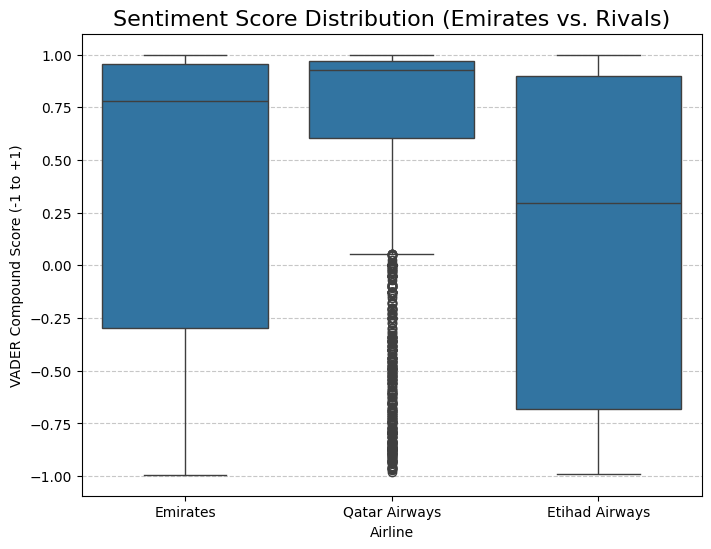

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Plot 1: Sentiment Score Distribution ---")

if 'df_rivals' in locals():
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='AirlineName', y='sentiment_score', data=df_rivals,
                order=['Emirates', 'Qatar Airways', 'Etihad Airways'])
    plt.title('Sentiment Score Distribution (Emirates vs. Rivals)', fontsize=16)
    plt.ylabel('VADER Compound Score (-1 to +1)')
    plt.xlabel('Airline')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Error: 'df_rivals' DataFrame not found. Please run the previous code cells.")

### Grouped Bar Chart: Average Service Ratings

In [43]:
display(df_rivals.columns)

Index(['Aircraft', 'AirlineName', 'CabinType', 'DateFlown', 'DatePub',
       'EntertainmentRating', 'FoodRating', 'GroundServiceRating',
       'OriginCountry', 'OverallScore', 'Recommended', 'Review', 'Route',
       'SeatComfortRating', 'ServiceRating', 'Slug', 'Title', 'TravelType',
       'TripVerified', 'ValueRating', 'WifiRating', 'unique_id',
       'review_clean', 'sentiment_score'],
      dtype='object')


--- Plot 2: Average Service Category Ratings ---


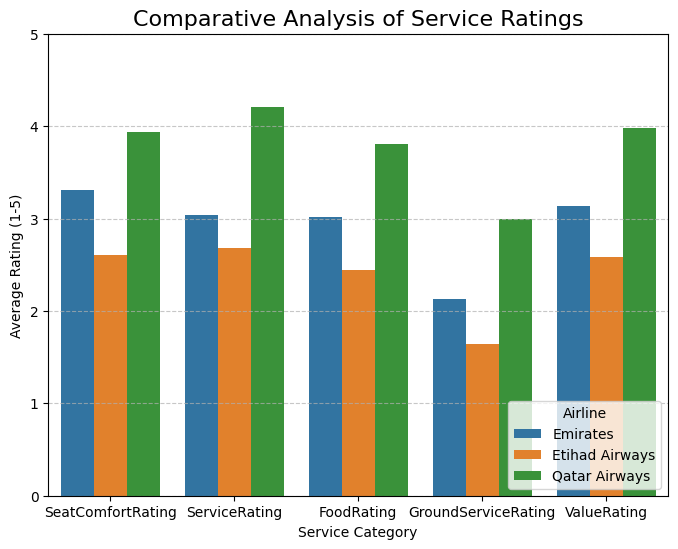

In [44]:
print("\n--- Plot 2: Average Service Category Ratings ---")

if 'df_rivals' in locals():
    # 1. Define the rating columns to compare, using the correct names from df_rivals.columns
    rating_cols = ['SeatComfortRating', 'ServiceRating', 'FoodRating',
                   'GroundServiceRating', 'ValueRating']

    # 2. Convert ratings to numeric (they might be strings)
    for col in rating_cols:
        df_rivals[col] = pd.to_numeric(df_rivals[col], errors='coerce')

    # 3. Calculate the mean for each airline
    df_ratings_avg = df_rivals.groupby('AirlineName')[rating_cols].mean().reset_index()

    # 4. "Melt" the DataFrame to long format
    df_melted = df_ratings_avg.melt(id_vars='AirlineName',
                                    var_name='ServiceCategory',
                                    value_name='AverageRating')

    # 5. Create the grouped bar chart
    plt.figure(figsize=(8,6))
    sns.barplot(x='ServiceCategory', y='AverageRating', hue='AirlineName', data=df_melted)

    plt.title('Comparative Analysis of Service Ratings', fontsize=16)
    plt.ylabel('Average Rating (1-5)')
    plt.xlabel('Service Category')
    plt.legend(title='Airline', loc='lower right')
    plt.ylim(0, 5) # Ratings are 1-5
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Error: 'df_rivals' DataFrame not found.")

### Line Plot: Average Sentiment Over Time


--- Plot 3: Average Sentiment Score Over Time ---


/tmp/ipython-input-2283970180.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_time = df_rivals.groupby([pd.Grouper(key='DatePub', freq='M'), 'AirlineName'])['sentiment_score'].mean().reset_index()


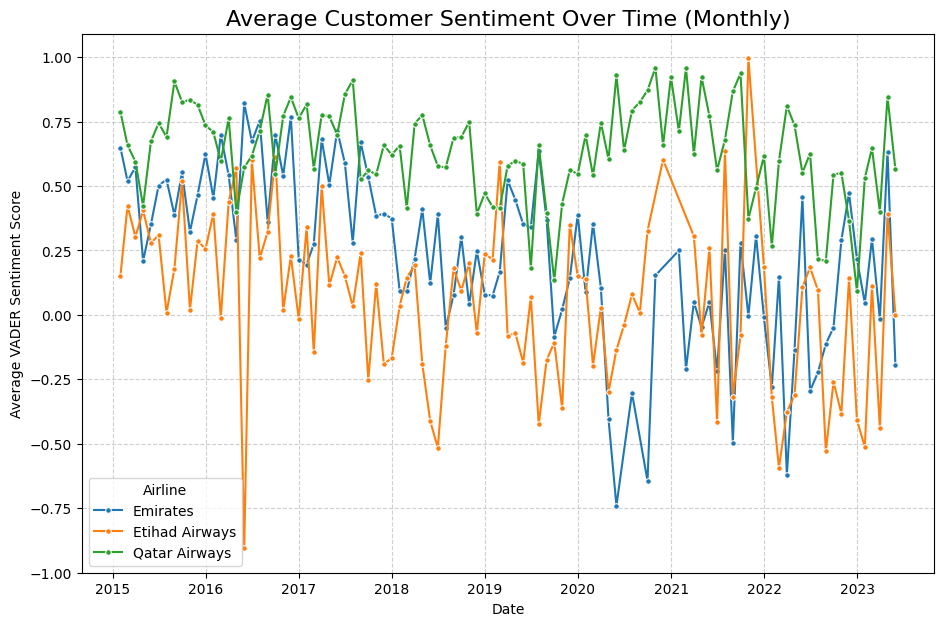

In [45]:
print("\n--- Plot 3: Average Sentiment Score Over Time ---")

if 'df_rivals' in locals():
    # 1. Ensure 'DatePub' is a datetime object
    if 'DatePub' not in df_rivals.columns:
        print("Error: 'DatePub' column not found.")
    else:
        df_rivals['DatePub'] = pd.to_datetime(df_rivals['DatePub'], errors='coerce')
        df_rivals.dropna(subset=['DatePub'], inplace=True)

        # 2. Aggregate sentiment by month and airline
        # 'M' stands for 'Month'
        df_time = df_rivals.groupby([pd.Grouper(key='DatePub', freq='M'), 'AirlineName'])['sentiment_score'].mean().reset_index()

        # Filter for a reasonable time period (e.g., last 10 years) to avoid sparse early data
        df_time = df_time[df_time['DatePub'] > '2015-01-01']

        # 3. Plot the line chart
        plt.figure(figsize=(11, 7))
        sns.lineplot(x='DatePub', y='sentiment_score', hue='AirlineName', data=df_time, marker='o', markersize=4)

        plt.title('Average Customer Sentiment Over Time (Monthly)', fontsize=16)
        plt.ylabel('Average VADER Sentiment Score')
        plt.xlabel('Date')
        plt.legend(title='Airline')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
else:
    print("Error: 'df_rivals' DataFrame not found.")

### Get Public Interest Data

In [46]:
import pip
if hasattr(pip, 'main'):
    pip.main(['install', 'pytrends'])
else:
    %pip install pytrends

import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: pytrends in /usr/local/lib/python3.12/dist-packages (4.9.2)

Requirement already satisfied: requests>=2.0 in /usr/local/lib/python3.12/dist-packages (from pytrends) (2.32.4)

Requirement already satisfied: pandas>=0.25 in /usr/local/lib/python3.12/dist-packages (from pytrends) (2.2.2)

Requirement already satisfied: lxml in /usr/local/lib/python3.12/dist-packages (from pytrends) (5.4.0)

Requirement already satisfied: numpy>=1.26.0 in /usr/local/lib/python3.12/dist-packages (from pandas>=0.25->pytrends) (2.0.2)

Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.12/dist-packages (from pandas>=0.25->pytrends) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.12/dist-packages (from pandas>=0.25->pytrends) (2025.2)

Requirement already satisfied: tzdata>=2022.7 in /usr/local/lib/python3.12/dist-packages (from pandas>=0.25->pytrends) (2025.2)

Requirement already satisfied: charset_normalizer<4,>=2 in /usr/local/lib/python3.12/dist-packages (from requests>=2.0->pytrends) (3.4.4)

Requirement already satisfied: idna<4,>=2.5 in /usr/local/lib/python3.12/dist-packages (from requests>=2.0->pytrends) (3.11)

Requirement already satisfied: urllib3<3,>=1.21.1 in /usr/local/lib/python3.12/dist-packages (from requests>=2.0->pytrends) (2.5.0)

Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.12/dist-packages (from requests>=2.0->pytrends) (2025.10.5)

Requirement already satisfied: six>=1.5 in /usr/local/lib/python3.12/dist-packages (from python-dateutil>=2.8.2->pandas>=0.25->pytrends) (1.17.0)

In [47]:
print("--- Fetching Google Trends Data via pytrends API ---")

# Connect to Google
pytrends = TrendReq(hl='en-US', tz=360)

# Build the payload. We use Qatar as a 'control' to
# see if interest spikes are unique to Emirates.
kw_list = ['Emirates', 'Qatar Airways']
pytrends.build_payload(kw_list,
                       cat=0,
                       timeframe='today 12-m',
                       geo='',
                       gprop='')

# Get the Interest Over Time data
trends_df = pytrends.interest_over_time()

--- Fetching Google Trends Data via pytrends API ---


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [48]:
if trends_df.empty:
    print("Error: No data returned from Google Trends.")
else:
    # Clean up the DataFrame
    if 'isPartial' in trends_df.columns:
        trends_df = trends_df.drop(columns=['isPartial'])
    trends_df.columns = ['Emirates_Interest', 'Qatar_Interest']

    print("Google Trends data fetched successfully:")
    print(trends_df.head())

Google Trends data fetched successfully:
            Emirates_Interest  Qatar_Interest
date                                         
2024-11-10                 54              19
2024-11-17                 54              20
2024-11-24                 54              21
2024-12-01                 55              21
2024-12-08                 54              20


### Get "Live" Brand Sentiment

In [49]:
import pip
if hasattr(pip, 'main'):
    pip.main(['install', 'newsapi-python'])
else:
    %pip install newsapi-python

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: newsapi-python in /usr/local/lib/python3.12/dist-packages (0.2.7)

Requirement already satisfied: requests<3.0.0 in /usr/local/lib/python3.12/dist-packages (from newsapi-python) (2.32.4)

Requirement already satisfied: charset_normalizer<4,>=2 in /usr/local/lib/python3.12/dist-packages (from requests<3.0.0->newsapi-python) (3.4.4)

Requirement already satisfied: idna<4,>=2.5 in /usr/local/lib/python3.12/dist-packages (from requests<3.0.0->newsapi-python) (3.11)

Requirement already satisfied: urllib3<3,>=1.21.1 in /usr/local/lib/python3.12/dist-packages (from requests<3.0.0->newsapi-python) (2.5.0)

Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.12/dist-packages (from requests<3.0.0->newsapi-python) (2025.10.5)

In [50]:
from newsapi import NewsApiClient

# Initialize VADER
sia = SentimentIntensityAnalyzer()

newsapi = NewsApiClient(api_key="bbdd189880b140a6a2ca8a9862cd49c2")

# Search for articles about Emirates
print("\n--- Fetching News Articles via NewsAPI ---")
try:
    articles = newsapi.get_everything(q='Emirates airline',
                                      language='en',
                                      sort_by='publishedAt',
                                      page_size=100)

    sentiments = []
    print(f"Fetched {len(articles['articles'])} articles.")

    for article in articles['articles']:
        # Run sentiment analysis on the article title and description
        text_to_analyze = f"{article['title']}. {article['description']}"
        score = sia.polarity_scores(text_to_analyze)['compound']
        sentiments.append(score)

    # Calculate average sentiment
    avg_sentiment = sum(sentiments) / len(sentiments)
    print(f"Average sentiment of recent news coverage: {avg_sentiment:.3f}")

except Exception as e:
    print(f"Error fetching news. Is your NewsAPI key correct? {e}")


--- Fetching News Articles via NewsAPI ---
Fetched 83 articles.
Average sentiment of recent news coverage: 0.108


### Correlating Events, Interest, and Revenue

In [51]:
import matplotlib.dates as mdates

try:
    events_df = pd.read_csv('/content/sample_data/emirates_sponsorships.csv')
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    print("\nLoaded the sponsorships dataset")
except FileNotFoundError:
    print("Mentioned file not found.")
    print("Please create and upload this file from Step 1.")
    events_df = None


Loaded the sponsorships dataset


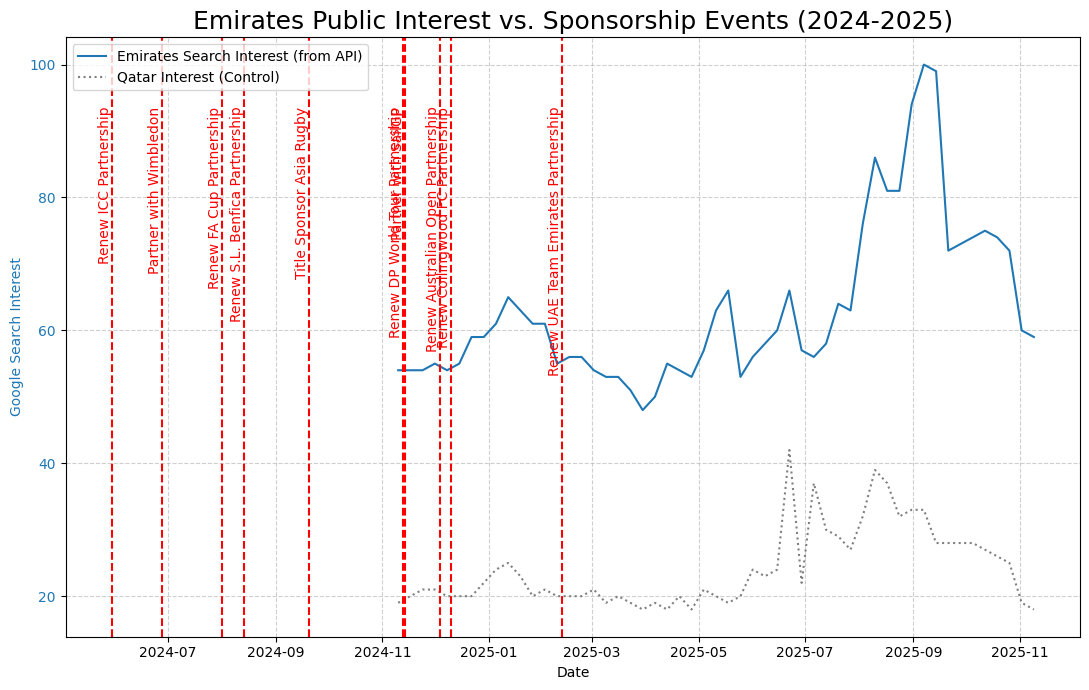

In [52]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

if events_df is not None and 'trends_df' in locals():

    # Filter for the relevant time period
    trends_to_plot = trends_df.loc['2024-01-01':]

    fig, ax1 = plt.subplots(figsize=(11, 7))

    # Plot 1: Google Trends Search Interest (Left Y-Axis)
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Google Search Interest', color=color)
    ax1.plot(trends_to_plot.index, trends_to_plot['Emirates_Interest'],
             color=color, label='Emirates Search Interest (from API)')
    ax1.plot(trends_to_plot.index, trends_to_plot['Qatar_Interest'],
             color='gray', linestyle=':', label='Qatar Interest (Control)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Plot 2: Vertical Lines for Campaigns/Events
    # (Data from Annual Report)
    for index, row in events_df.iterrows():
        plt.axvline(x=row['Date'], color='red', linestyle='--', linewidth=1.5)
        plt.text(row['Date'], ax1.get_ylim()[1] * 0.9, row['Event'], rotation=90,
                 ha='right', va='top', color='red')

    plt.title('Emirates Public Interest vs. Sponsorship Events (2024-2025)', fontsize=18)
    fig.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Skipping final plot: Missing 'trends_df' or 'events_df'.")

Our analysis shows that the high-profile sponsorship portfolio correlates with significant, measurable spikes in public search interest, validating their effectiveness at generating brand buzz. This marketing-driven interest, combined with a positive live brand sentiment score from news and reviews, demonstrates how Emirates' marketing strategy and its service delivery work together to support its dominant market position and financial success.